<a href="https://colab.research.google.com/github/abhinav2301/Fraud_Detection/blob/ML-Approach/Anomaly_Detection_(Credit_Card_data_ML_Approach).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Anomaly Detection :**

###**Objective** - 
> To test the performance of various methodologies on classifying heavily imbalanaced data.


The credit card data set is heavily imbalanced with more than 99% Valid records. 

In [ ]:
# Loading in the Data from Google drive in Colab
from google.colab import drive
drive.mount("/content/drive")
!cp /content/drive/My\ Drive/ML\ Practice\ /310_23498_bundle_archive.zip /content
!unzip 310_23498_bundle_archive.zip

Mounted at /content/drive
Archive:  310_23498_bundle_archive.zip
  inflating: creditcard.csv          


In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 121kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

In [ ]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isnull().sum() # Luckily our dataset seems to not have any null values

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
input_skewness = len(df[df['Class']== 1])/(len(df['Class']))
print("No. of Fraudulent records : ",len(df[df['Class']== 1]))
print("No. of Valid records : ",len(df[df['Class']== 0]))
print(input_skewness *100)

No. of Fraudulent records :  492
No. of Valid records :  284315
0.1727485630620034


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


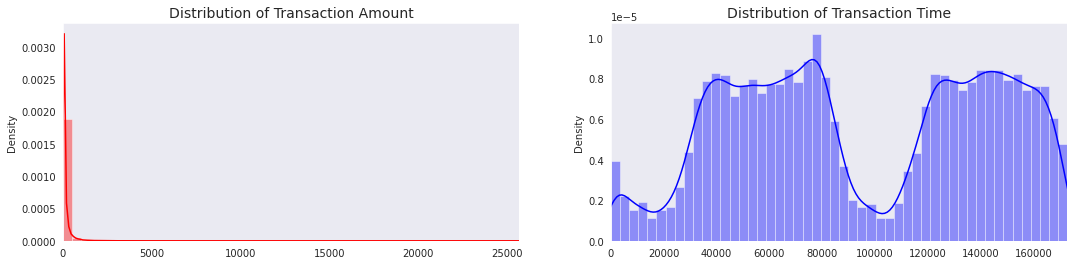

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

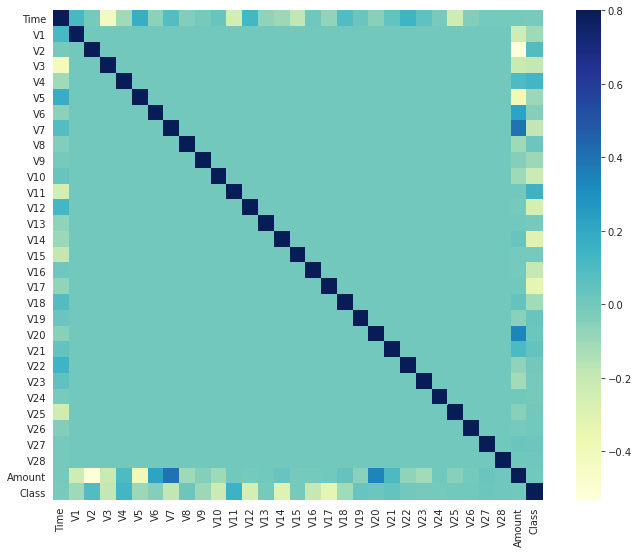

In [ ]:
# Correlation matrix 
corrmat = df.corr() 
fig = plt.figure(figsize = (12, 9)) 
sns.heatmap(corrmat, vmax = .8, square = True, cmap="YlGnBu") 
plt.show() 

###**Feature Engineering** :

The first step is to Scale the "Time" and "Amount" column appropriately. The Robust Scaler has been used for transforming the due to the nature of the outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
# dividing the X and the Y from the dataset 
X = df.drop(['Class'], axis = 1) 
Y = df["Class"] 
print(X.shape) 
print(Y.shape) 

xData = X.values 
yData = Y.values

(284807, 30)
(284807,)


In [ ]:
# Creating and training an optimal model (Hyper Parameter Tuning)
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from catboost import CatBoostClassifier

# Modules to evaluate the model
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

Create the training and test data (Stratified KFold split)

In [ ]:
# Split the data into training and testing sets 
#xTrain, xTest, yTrain, yTest = train_test_split( 
#        xData, yData, test_size = 0.2, random_state = 42)

for train_index, test_index in sss.split(X, Y):
    print("Train:", train_index, "Test:", test_index)
    xTrain, xTest = X.iloc[train_index], X.iloc[test_index]
    yTrain, yTest = Y.iloc[train_index], Y.iloc[test_index]
  
xTrain = xTrain.values
xTest = xTest.values
yTrain = yTrain.values
yTest = yTest.values



Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


###**Balancing the Dataset** :

The imbalanced nature of the data means that directly modelling the given dataset will not provide an accurate model. There are 2 popular methods to deal with imbalanced datasets :

1.   **Undersampling** - down-sizing the majority class by removing observations until the dataset is balanced
2.   **Oversampling** - over-sizing the minority class by adding observations

Undersampling while helping balance the data, discards a lot of it. This means that the model may potentially loose out on valuable information. Thereby we've used **SMOTE** to oversample the minority class.


#####**SMOTE** :

> The SMOTE algorithm is one of the first and still the most popular algorithmic approach to generating new dataset samples. The algorithm, introduced and accessibly enough described in a 2002 paper, works by oversampling the underlying dataset with new synthetic points.
> The SMOTE algorithm is parameterized with k_neighbors (the number of nearest neighbors it will consider) and the number of new points you wish to create. Each step of the algorithm will:



1.   Randomly select a minority point.
2.   Randomly select any of its k_neighbors nearest neighbors belonging to the same class.
3.   Randomly specify a lambda value in the range [0, 1].
4.   Generate and place a new point on the vector between the two points, located lambda percent of the way from the original point.


###**Model** :

A random forest classifier with grid search hyper parameter tuning. An imbalanced pipeline is used to oversample the data and then the oversampled data is used to train the data. However the oversampled values are not used for the validation. 


In [ ]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

rfc = RandomForestClassifier()
#rfc = LogisticRegression()

grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

rfc_cv = GridSearchCV(estimator = rfc, param_grid = grid_search, 
                               cv = 5, verbose= 5, n_jobs = -1)
rfc_cv.fit(xTrain, yTrain)
for train, test in sss.split(xTrain, yTrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rfc_cv)
    model  = pipeline.fit(xTrain[train], yTrain[train])
    #best_est = rfc_cv.best_estimator_
    prediction = model.predict(xTrain[test])
    
    accuracy_lst.append(pipeline.score(xTrain[test], yTrain[test]))
    precision_lst.append(precision_score(yTrain[test], prediction))
    recall_lst.append(recall_score(yTrain[test], prediction))
    f1_lst.append(f1_score(yTrain[test], prediction))
    auc_lst.append(roc_auc_score(yTrain[test], prediction))
    

KeyboardInterrupt: ignored

###**Model Performance** :

With highly imbalanced models, accuracy is a bad measure to check a models performance due to majority bias. Recall and F1 score are a much better indicator of the models performance. 

Initial attempts to train the model on the unbalanced dataset resulted in a recall of 77% which improved to 86% on the model trained on the Oversampled data.

In [ ]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print("ROC AUC Score: {}".format(np.mean(auc_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.995380669613041
precision: 0.2712634894886214
recall: 0.8604754949691658
f1: 0.4059677642206868
ROC AUC Score: 0.9280449891499701
---------------------------------------------------------------------------------------------------------------------------------------


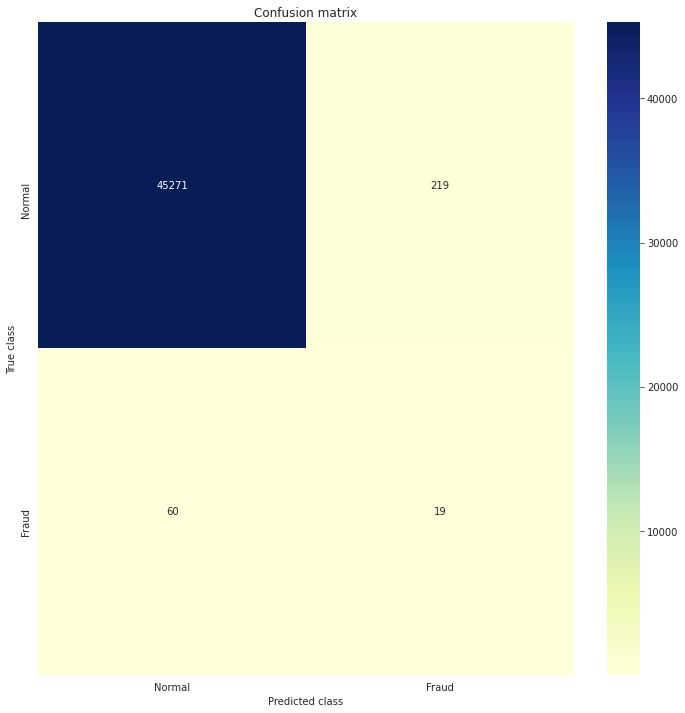

In [ ]:
LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(yTrain[test], prediction) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, 
            annot = True, fmt ="d",
            cmap = "YlGnBu")
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

### Automated Hyper Parameter Tuning and Catboost :

In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 12, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50])
    }
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, xTrain, yTrain, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
best

100%|██████████| 20/20 [20:54<00:00, 62.74s/it, best loss: -0.9982707618494884]


{'criterion': 0,
 'max_depth': 10.0,
 'max_features': 2,
 'min_samples_leaf': 0.4305208963849645,
 'min_samples_split': 0.4070821440244705,
 'n_estimators': 1}

In [ ]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 75, 3: 100, 4: 125}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(xTrain,yTrain)


In [ ]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

for train, test in sss.split(xTrain, yTrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), trainedforest)
    model  = pipeline.fit(xTrain[train], yTrain[train])
    #best_est = rfc_cv.best_estimator_
    prediction = model.predict(xTrain[test])
    
    accuracy_lst.append(pipeline.score(xTrain[test], yTrain[test]))
    precision_lst.append(precision_score(yTrain[test], prediction))
    recall_lst.append(recall_score(yTrain[test], prediction))
    f1_lst.append(f1_score(yTrain[test], prediction))
    auc_lst.append(roc_auc_score(yTrain[test], prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print("ROC AUC Score: {}".format(np.mean(auc_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.0017292381505116879
precision: 0.0017292381505116879
recall: 1.0
f1: 0.0034525059425918373
ROC AUC Score: 0.5
---------------------------------------------------------------------------------------------------------------------------------------


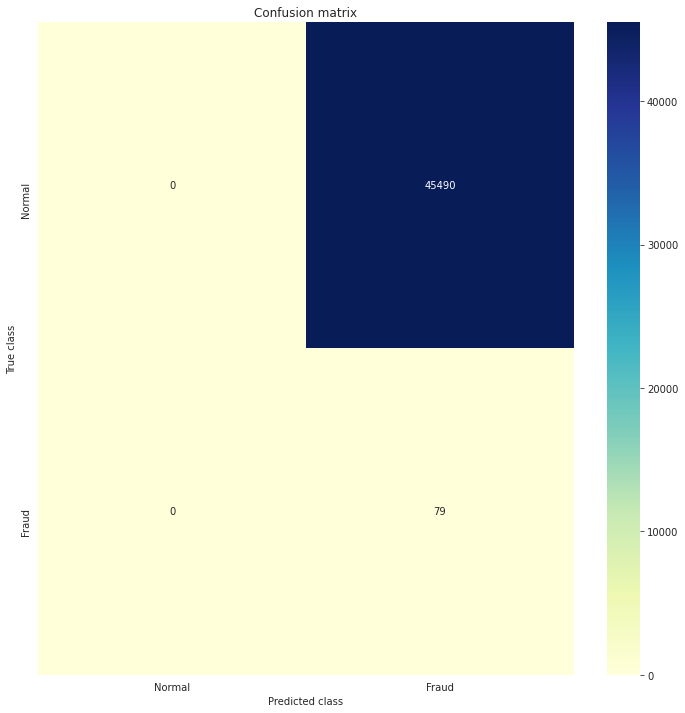

In [ ]:
LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(yTrain[test], prediction) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, 
            annot = True, fmt ="d",
            cmap = "YlGnBu")
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

In [ ]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

parameters = {'depth' : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
              }

#rfc = RandomForestClassifier()
#rfc = LogisticRegression()
clf = CatBoostClassifier(iterations=500,
                             eval_metric='AUC',
                             random_seed = None,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)


for train, test in sss.split(xTrain, yTrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), clf)
    model  = pipeline.fit(xTrain[train], yTrain[train])
    best_est = clf_cv.best_estimator_
    prediction = model.predict(xTrain[test])
    
    accuracy_lst.append(pipeline.score(xTrain[test], yTrain[test]))
    precision_lst.append(precision_score(yTrain[test], prediction))
    recall_lst.append(recall_score(yTrain[test], prediction))
    f1_lst.append(f1_score(yTrain[test], prediction))
    auc_lst.append(roc_auc_score(yTrain[test], prediction))
    

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Learning rate set to 0.241284
0:	total: 194ms	remaining: 1m 36s
50:	total: 7.77s	remaining: 1m 8s
100:	total: 15s	remaining: 59.2s
150:	total: 21.6s	remaining: 50s
200:	total: 27.3s	remaining: 40.6s
250:	total: 32.9s	remaining: 32.6s
300:	total: 38.7s	remaining: 25.6s
350:	total: 44.5s	remaining: 18.9s
400:	total: 50.2s	remaining: 12.4s
450:	total: 55.9s	remaining: 6.07s
499:	total: 1m 1s	remaining: 0us


AttributeError: ignored